In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.transforms.functional as TF

from miniai.data import *
from miniai.plotting import *
from miniai.learner import Learner, TrainLearner, MomentumLearner
from miniai.callbacks import *

mpl.rcParams['image.cmap'] = 'Greys'

In [2]:
data = pd.read_csv('data/fashion_mnist/train.csv')
data_test = pd.read_csv('data/fashion_mnist/test.csv')

In [3]:
X_train = (tensor(data.iloc[:, 1:].values)/255.).view(-1, 1, 28, 28)
y_train = tensor(data.iloc[:, 0].values)
X_valid = (tensor(data_test.iloc[:, 1:].values)/255.).view(-1, 1, 28, 28)
y_valid = tensor(data_test.iloc[:, 0].values)

In [4]:
class FashionDataset(Dataset):
    def __init__(self, x, y, mean=None, std=None):
        x = TF.resize(x, (32, 32))
        self.mean = mean; self.std = std
        if self.mean is None: self.mean = x.mean()
        if self.std is None: self.std = x.std()
        self.x = (x - self.mean) / self.std
        self.y = y

In [5]:
dset_train = FashionDataset(X_train[:2000], y_train[:2000])
dset_valid = FashionDataset(X_valid[:2000], y_valid[:2000], dset_train.mean, dset_train.std)

/home/pika228/mambaforge/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
dl_train = DataLoader(dset_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid = DataLoader(dset_valid, batch_size=128, shuffle=False, num_workers=4)
dls = DataLoaders(dl_train, dl_valid)

In [7]:
X_b, y_b = next(iter(dls.train))

In [8]:
X_b.shape

torch.Size([128, 1, 32, 32])

<br>**Model**

In [ ]:
from diffusers import UNet2DModel
# Unet with random weights; not trained
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
model.eval()

In [56]:
@torch.no_grad()
def sample(model, sz, β, T=1000, num_steps=30):
    xt = torch.randn(*sz)
    for t in range(T-1, 50, -T//num_steps):
        ε = model(xt, t).sample.detach()
        xt = (xt - ε*β[t]) / (1.-β[t])
    return xt

In [22]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, βmin, βmax, T):
        self.T = T
        self.β = torch.linspace(βmin, βmax, T, device=def_device).reshape(-1, 1, 1, 1).to(def_device)
        self.α_bar = torch.cumprod(1.-self.β, dim=0).to(def_device)
        self.sigmas = self.β.sqrt().to(def_device)
    def before_batch(self, learn):
        x0 = learn.batch[0]
        ε = torch.randn_like(x0, device=def_device)
        t = torch.randint(0, self.T, (x0.shape[0],), dtype=torch.long, device=def_device)
        xt = x0*self.α_bar.sqrt() + ε*(1.-self.α_bar).sqrt()
        learn.batch = ((xt, t), ε)
    def after_batch(self, learn):
        learn.batch = to_device(learn.batch, 'cpu')
    def after_fit(self, learn):
        self.β = self.β.to('cpu')
        self.α_bar = self.α_bar.to('cpu')
        self.sigmas = self.sigmas.to('cpu')
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[0]).sample

In [24]:
ddpmCB = DDPMCB(1e-4, 0.2, 1000)
#learn = Learner(dls, model, nn.MSELoss(), lr=3e-4, cbs=[ddpmCB, MetricCB(), ProgressCB()])

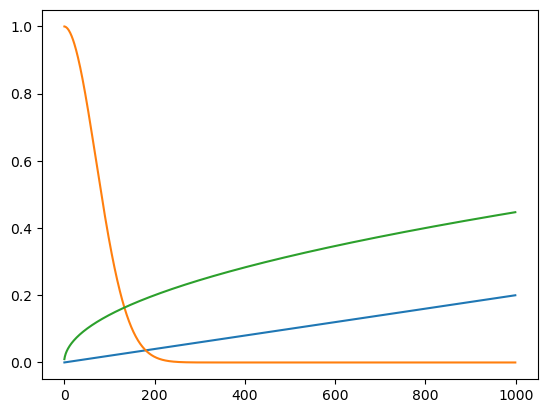

In [25]:
plt.plot(ddpmCB.β.squeeze()); plt.plot(ddpmCB.α_bar.squeeze()); plt.plot(ddpmCB.sigmas.squeeze()); 

<br><br> **Inference**

In [15]:
model = torch.load('./models/unet.pth', map_location='cpu')
model.eval()

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [31]:
t = 100
denoised_images = model(X_b, t).sample.detach()

In [36]:
x0_pred = (X_b - denoised_images*ddpmCB.β[t]) / (1.-ddpmCB.β[t])

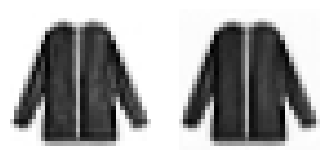

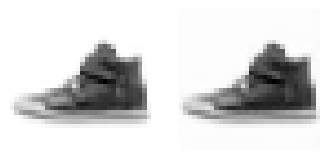

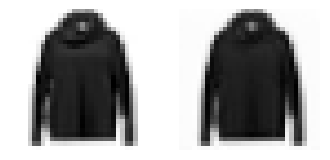

In [41]:
show_images([X_b[0], x0_pred[0]]);
show_images([X_b[1], x0_pred[1]]);
show_images([X_b[2], x0_pred[2]]);

In [57]:
sample(model, [1, 1, 32, 32], ddpmCB.β)

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])